In [1]:
! pip install lambeq
! pip install pytket-qiskit
! pip install nltk
!brew install portaudio
!pip install sounddevice

BATCH_SIZE = 30
LEARNING_RATE = 3e-2
EPOCHS = 4000
SEED = 0

You should consider upgrading via the '/Library/Frameworks/Python.framework/Versions/3.9/bin/python3 -m pip install --upgrade pip' command.


You should consider upgrading via the '/Library/Frameworks/Python.framework/Versions/3.9/bin/python3 -m pip install --upgrade pip' command.
You should consider upgrading via the '/Library/Frameworks/Python.framework/Versions/3.9/bin/python3 -m pip install --upgrade pip' command.
Running `brew update --auto-update`...
==> Auto-updated Homebrew!
Updated 1 tap (homebrew/core).

To reinstall 19.7.0, run:
  brew reinstall portaudio
You should consider upgrading via the '/Library/Frameworks/Python.framework/Versions/3.9/bin/python3 -m pip install --upgrade pip' command.


In [2]:
# 1. Create LL(1) parse table for our musical context-free grammar

primary_elements = ['p4', 'p5', 'p7', 'p9', 'p1', 'p2', 'p3', 'p6', 'p8']
secondary_elements = ['s1', 's2', 's3', 's4']
tertiary_elements = ['t1', 't2', 't3']
ground_elements = ['g1', 'g2']

basic_rule = ('M', 'E2')
compo_rule = ('E3', 'S', 'S')
motif_rule = ('E1', 'E1', 'E1', 'E1')

table = {
    'S': {
        'E3': compo_rule,
        'E1': basic_rule,
    },
    'M': {
        'E1': ('E1', 'E1', 'E1', 'E1')
    },
    'E1': {p: (p,) for p in primary_elements},
    'E2': {s: (s,) for s in secondary_elements},
    'E3': {t: (t,) for t in tertiary_elements}
}

table['S'].update({g: (g,) for g in ground_elements})
table['S'].update({p: basic_rule for p in primary_elements})
table['S'].update({t: compo_rule for t in tertiary_elements})
table['M'].update({p: motif_rule for p in primary_elements})

In [3]:
# 2. Represent the production rules as boxes in discopy

from discopy import Box, Id, Ty, Word

e1 = Ty('e1') # Primary musical element
e2 = Ty('e2') # Seconday musical element
e3 = Ty('e3') # Tertiary musical element
m  = Ty('m')  # Musical motif

# Atomic pregroup types
n = Ty('n')
s = Ty('s')

basic_seq = Box('b_seq', m @ e2, s)
compo_seq = Box('c_seq', e3 @ s @ s, s)
motif = Box('motif', e1 @ e1 @ e1 @ e1, m)

rule_box = {
    basic_rule: basic_seq,
    compo_rule: compo_seq,
    motif_rule: motif
}

rule_box.update({(p,): Word(p, e1) for p in primary_elements})
rule_box.update({(s,): Word(s, e2) for s in secondary_elements})
rule_box.update({(t,): Word(t, e3) for t in tertiary_elements})
rule_box.update({(g,): Word(g, s) for g in ground_elements})

In [4]:
# 3. Implement an LL(1) parser.

def parse(sentence):
    stack = ['S']
    diagram = Id(s)
    while len(sentence) > 0:
        w = sentence[0]
        if len(stack) == 0:
            raise Exception(f'Unexpected token {w}.')
        top = stack.pop(0)
        if top == w:
            sentence.pop(0)
            continue
        if top not in table:
            raise Exception(f'{top} not recognised.')
        if w not in table[top]:
            raise Exception(f'No rule for [{top}, {w}].')
        rule = table[top][w]
        stack = list(rule) + stack
        diagram <<= rule_box[rule] @ Id(diagram.dom[1:])
    if len(stack) > 0:
        raise Exception('Unexpected end of sentence.')
    return diagram

t3 p8 p1 p8 p1 s4 g1


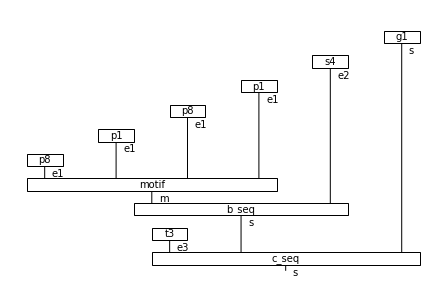

In [5]:
# 4. Parse corpus from text

from jax import numpy as np


def read_data(filename):
    labels, sentences = [], []
    with open(filename) as f:
        for line in f:
            labels.append([1, 0] if line[:3] == 'RIT' else [0, 1])
            sentences.append(line[3:].strip())
    return np.array(labels), sentences


train_labels, train_data = read_data('datasets/music_train_data.txt')
dev_labels, dev_data = read_data('datasets/music_dev_data.txt')
test_labels, test_data = read_data('datasets/music_test_data.txt')

train_parses = [parse(sentence.split(' ')) for sentence in train_data]
dev_parses = [parse(sentence.split(' ')) for sentence in dev_data]
test_parses = [parse(sentence.split(' ')) for sentence in test_data]

print(train_data[1])
train_parses[1].draw()

In [6]:
# 5. Define functor from our musical context-free grammar to musical pregroups

from discopy import Diagram, Functor

pg_types = {
    e1: n,
    e2: (n @ n @ n @ n).r @ s,
    e3: s @ s.l @ s.l,
    s: s
}

pg_rule_reductions = {
    motif: Id(n @ n @ n @ n),
    basic_seq: Diagram.cups(n @ n @ n @ n, (n @ n @ n @ n).r) @ Id(s),
    compo_seq: Id(s) @ Diagram.cups(s.l @ s.l, s @ s)
}

def pg_reductions(ar):
    if ar in pg_rule_reductions:
        return pg_rule_reductions[ar]
    if isinstance(ar, Word):
        return Word(ar.name, pg_types[ar.cod])
    raise Exception(f"Unexpected box {ar}.")

    
cfg2pg = Functor(ob=pg_types, ar=pg_reductions)

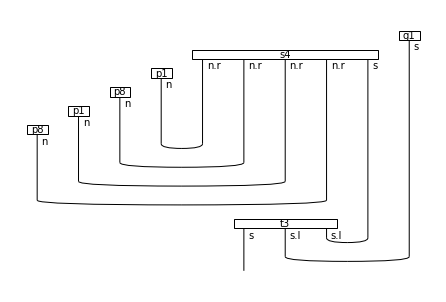

In [7]:
# 6. Convert parses into discocat diagrams

train_diagrams = [cfg2pg(parse) for parse in train_parses]
dev_diagrams = [cfg2pg(parse) for parse in dev_parses]
test_diagrams = [cfg2pg(parse) for parse in test_parses]

train_diagrams[1].draw()

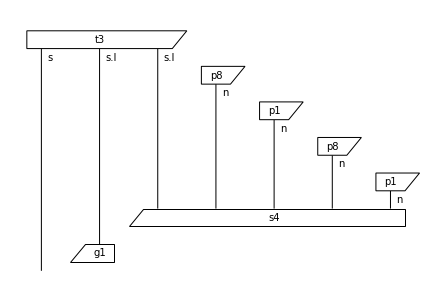

In [8]:
# 8. Remove cups from pregroup diagrams
from lambeq import remove_cups


simple_train_diagrams = [remove_cups(parse) for parse in train_diagrams]
simple_dev_diagrams = [remove_cups(parse) for parse in dev_diagrams]
simple_test_diagrams = [remove_cups(parse) for parse in test_diagrams]

simple_train_diagrams[1].draw()

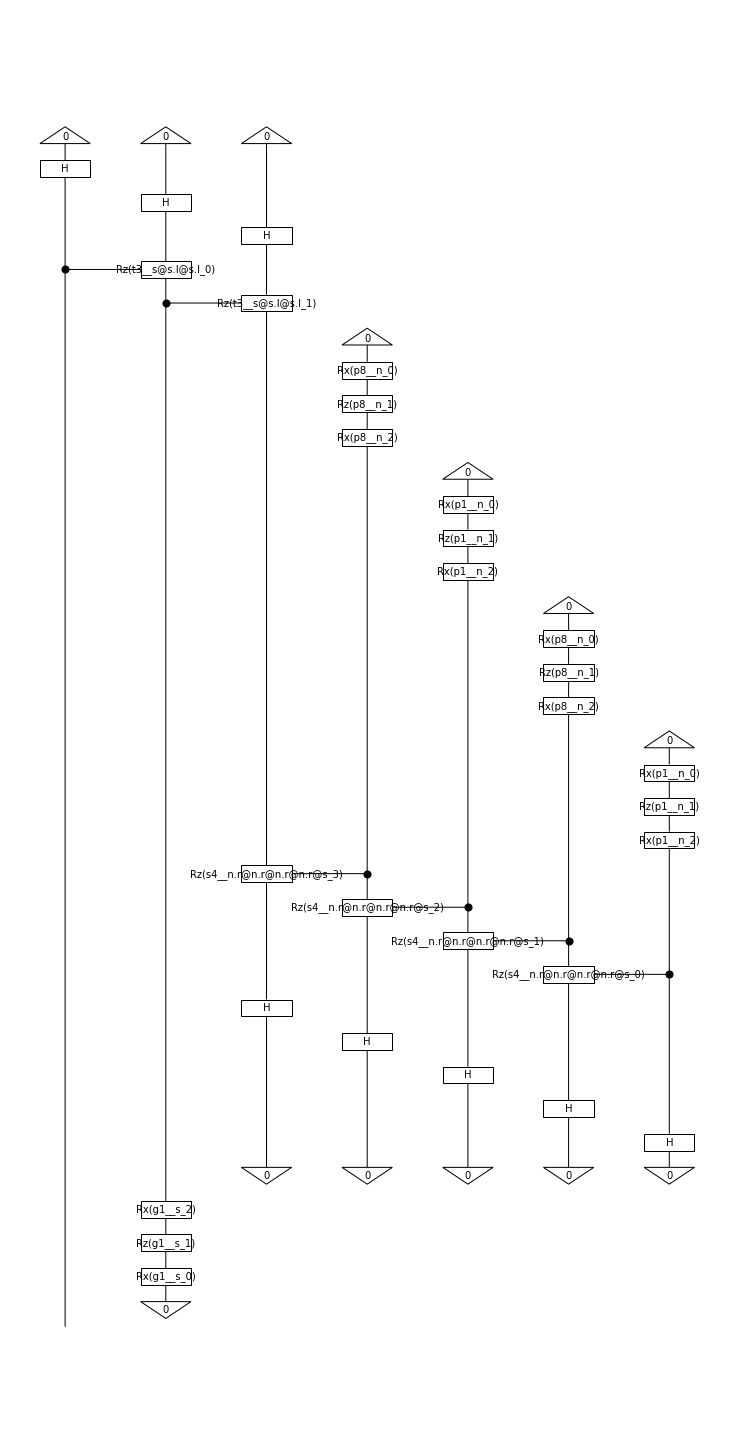

In [9]:
# 9. Use lambeq to convert rewritten diagrams to circuits

from lambeq import AtomicType, IQPAnsatz



ansatz = IQPAnsatz({AtomicType.NOUN: 1, AtomicType.SENTENCE: 1},
                   n_layers=1, n_single_qubit_params=3)


train_circuits = [ansatz(diagram) for diagram in simple_train_diagrams]
dev_circuits =  [ansatz(diagram) for diagram in simple_dev_diagrams]
test_circuits = [ansatz(diagram) for diagram in simple_test_diagrams]

train_circuits[1].draw(figsize=(10, 20))

In [10]:
from lambeq import NumpyModel

all_circuits = train_circuits + dev_circuits + test_circuits

model = NumpyModel.from_diagrams(all_circuits, use_jit=True)

In [11]:
loss = lambda y_hat, y: -np.sum(y * np.log(y_hat)) / len(y)  # binary cross-entropy loss
acc = lambda y_hat, y: np.sum(np.round(y_hat) == y) / len(y) / 2  # half due to double-counting

In [12]:
from lambeq import QuantumTrainer, SPSAOptimizer

trainer = QuantumTrainer(
    model,
    loss_function=loss,
    epochs=EPOCHS,
    optimizer=SPSAOptimizer,
    optim_hyperparams={'a': 0.2, 'c': 0.06, 'A':0.01*EPOCHS},
    evaluate_functions={'acc': acc},
    evaluate_on_train=True,
    verbose = 'text',
    seed=0
)

In [13]:
from lambeq import Dataset

train_dataset = Dataset(
            train_circuits,
            train_labels,
            batch_size=BATCH_SIZE)

val_dataset = Dataset(dev_circuits, dev_labels, shuffle=False)

In [14]:
trainer.fit(train_dataset, val_dataset, logging_step=12)

Epoch 1:     train/loss: 0.7436   valid/loss: 0.6767   train/acc: 0.4600   valid/acc: 0.6800
Epoch 12:    train/loss: 0.6736   valid/loss: 0.5604   train/acc: 0.6600   valid/acc: 0.7600
Epoch 24:    train/loss: 0.6468   valid/loss: 0.5297   train/acc: 0.6800   valid/acc: 0.8400
Epoch 36:    train/loss: 0.6176   valid/loss: 0.5505   train/acc: 0.6600   valid/acc: 0.8000
Epoch 48:    train/loss: 0.5756   valid/loss: 0.5661   train/acc: 0.7400   valid/acc: 0.7600
Epoch 60:    train/loss: 0.5656   valid/loss: 0.5093   train/acc: 0.7000   valid/acc: 0.7200
Epoch 72:    train/loss: 0.5365   valid/loss: 0.4742   train/acc: 0.6800   valid/acc: 0.6800
Epoch 84:    train/loss: 0.5208   valid/loss: 0.4728   train/acc: 0.7800   valid/acc: 0.8000
Epoch 96:    train/loss: 0.4854   valid/loss: 0.4966   train/acc: 0.7800   valid/acc: 0.7200
Epoch 108:   train/loss: 0.4961   valid/loss: 0.4636   train/acc: 0.7400   valid/acc: 0.7600
Epoch 120:   train/loss: 0.4644   valid/loss: 0.4346   train/acc: 0.78

Epoch 1068:  train/loss: 0.2534   valid/loss: 0.6577   train/acc: 1.0000   valid/acc: 0.7600
Epoch 1080:  train/loss: 0.2895   valid/loss: 0.6652   train/acc: 0.9800   valid/acc: 0.7600
Epoch 1092:  train/loss: 0.2703   valid/loss: 0.6115   train/acc: 1.0000   valid/acc: 0.7600
Epoch 1104:  train/loss: 0.2813   valid/loss: 0.6227   train/acc: 1.0000   valid/acc: 0.7600
Epoch 1116:  train/loss: 0.2871   valid/loss: 0.5981   train/acc: 1.0000   valid/acc: 0.7600
Epoch 1128:  train/loss: 0.2504   valid/loss: 0.6122   train/acc: 1.0000   valid/acc: 0.7600
Epoch 1140:  train/loss: 0.2802   valid/loss: 0.6156   train/acc: 1.0000   valid/acc: 0.7600
Epoch 1152:  train/loss: 0.2705   valid/loss: 0.6423   train/acc: 1.0000   valid/acc: 0.7600
Epoch 1164:  train/loss: 0.2674   valid/loss: 0.6082   train/acc: 1.0000   valid/acc: 0.7600
Epoch 1176:  train/loss: 0.2506   valid/loss: 0.6079   train/acc: 1.0000   valid/acc: 0.7600
Epoch 1188:  train/loss: 0.2701   valid/loss: 0.5621   train/acc: 1.00

Epoch 2136:  train/loss: 0.2444   valid/loss: 0.3923   train/acc: 1.0000   valid/acc: 0.7600
Epoch 2148:  train/loss: 0.2300   valid/loss: 0.3890   train/acc: 1.0000   valid/acc: 0.7600
Epoch 2160:  train/loss: 0.2356   valid/loss: 0.3914   train/acc: 1.0000   valid/acc: 0.7600
Epoch 2172:  train/loss: 0.2207   valid/loss: 0.3921   train/acc: 0.9800   valid/acc: 0.7600
Epoch 2184:  train/loss: 0.2316   valid/loss: 0.3948   train/acc: 1.0000   valid/acc: 0.7600
Epoch 2196:  train/loss: 0.2308   valid/loss: 0.3911   train/acc: 1.0000   valid/acc: 0.7600
Epoch 2208:  train/loss: 0.2378   valid/loss: 0.3884   train/acc: 1.0000   valid/acc: 0.7600
Epoch 2220:  train/loss: 0.2352   valid/loss: 0.3898   train/acc: 1.0000   valid/acc: 0.7600
Epoch 2232:  train/loss: 0.2316   valid/loss: 0.3889   train/acc: 1.0000   valid/acc: 0.7600
Epoch 2244:  train/loss: 0.2255   valid/loss: 0.3908   train/acc: 1.0000   valid/acc: 0.7600
Epoch 2256:  train/loss: 0.2335   valid/loss: 0.3910   train/acc: 1.00

Epoch 3204:  train/loss: 0.2108   valid/loss: 0.3400   train/acc: 0.9800   valid/acc: 0.7600
Epoch 3216:  train/loss: 0.2074   valid/loss: 0.3383   train/acc: 1.0000   valid/acc: 0.7600
Epoch 3228:  train/loss: 0.2324   valid/loss: 0.3391   train/acc: 0.9800   valid/acc: 0.7600
Epoch 3240:  train/loss: 0.2051   valid/loss: 0.3370   train/acc: 0.9800   valid/acc: 0.7600
Epoch 3252:  train/loss: 0.2340   valid/loss: 0.3375   train/acc: 0.9600   valid/acc: 0.7600
Epoch 3264:  train/loss: 0.1994   valid/loss: 0.3383   train/acc: 0.9800   valid/acc: 0.7600
Epoch 3276:  train/loss: 0.2272   valid/loss: 0.3394   train/acc: 0.9800   valid/acc: 0.7600
Epoch 3288:  train/loss: 0.2133   valid/loss: 0.3373   train/acc: 0.9800   valid/acc: 0.7600
Epoch 3300:  train/loss: 0.2219   valid/loss: 0.3421   train/acc: 1.0000   valid/acc: 0.7600
Epoch 3312:  train/loss: 0.2075   valid/loss: 0.3429   train/acc: 0.9800   valid/acc: 0.7600
Epoch 3324:  train/loss: 0.2210   valid/loss: 0.3421   train/acc: 0.98

Test accuracy: 0.76


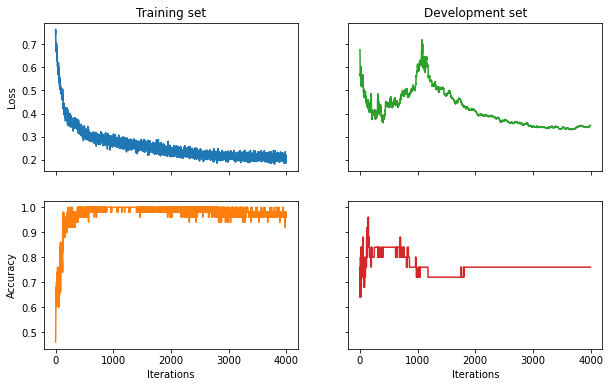

In [15]:
import matplotlib.pyplot as plt

fig, ((ax_tl, ax_tr), (ax_bl, ax_br)) = plt.subplots(2, 2, sharex=True, sharey='row', figsize=(10, 6))
ax_tl.set_title('Training set')
ax_tr.set_title('Development set')
ax_bl.set_xlabel('Iterations')
ax_br.set_xlabel('Iterations')
ax_bl.set_ylabel('Accuracy')
ax_tl.set_ylabel('Loss')

colours = iter(plt.rcParams['axes.prop_cycle'].by_key()['color'])
ax_tl.plot(trainer.train_epoch_costs, color=next(colours))
ax_bl.plot(trainer.train_results['acc'], color=next(colours))
ax_tr.plot(trainer.val_costs, color=next(colours))
ax_br.plot(trainer.val_results['acc'], color=next(colours))

test_acc = acc(model(test_circuits), test_labels)
print('Test accuracy:', test_acc)

In [16]:
def _measure_quantum_circuit_for_composition(composition):
    diagram = cfg2pg(parse(composition[:]))
    circ = ansatz(diagram)
    return model.get_diagram_output([circ])[0]

In [17]:
# from itertools import permutations
# valid_compositions = []
# elements = primary_elements + secondary_elements + tertiary_elements + ground_elements

# for i in range(6):
#     for c in permutations(elements, i):
#         try:
#             cfg2pg(parse(list(c)))
#             valid_compositions.append(list(c))
#             print(c)
#         except:
#             continue
# print(valid_compositions)

In [18]:
import pickle
COMPOSITIONS = pickle.load(open( "valid_compositions.p", "rb" ))
print (COMPOSITIONS)

if [] in COMPOSITIONS: COMPOSITIONS.remove([])

[['g1'], ['g2'], ['t1', 'g1', 'g2'], ['t1', 'g2', 'g1'], ['t2', 'g1', 'g2'], ['t2', 'g2', 'g1'], ['t3', 'g1', 'g2'], ['t3', 'g2', 'g1'], ['p4', 'p5', 'p7', 'p9', 's1'], ['p4', 'p5', 'p7', 'p9', 's2'], ['p4', 'p5', 'p7', 'p9', 's3'], ['p4', 'p5', 'p7', 'p9', 's4'], ['p4', 'p5', 'p7', 'p1', 's1'], ['p4', 'p5', 'p7', 'p1', 's2'], ['p4', 'p5', 'p7', 'p1', 's3'], ['p4', 'p5', 'p7', 'p1', 's4'], ['p4', 'p5', 'p7', 'p2', 's1'], ['p4', 'p5', 'p7', 'p2', 's2'], ['p4', 'p5', 'p7', 'p2', 's3'], ['p4', 'p5', 'p7', 'p2', 's4'], ['p4', 'p5', 'p7', 'p3', 's1'], ['p4', 'p5', 'p7', 'p3', 's2'], ['p4', 'p5', 'p7', 'p3', 's3'], ['p4', 'p5', 'p7', 'p3', 's4'], ['p4', 'p5', 'p7', 'p6', 's1'], ['p4', 'p5', 'p7', 'p6', 's2'], ['p4', 'p5', 'p7', 'p6', 's3'], ['p4', 'p5', 'p7', 'p6', 's4'], ['p4', 'p5', 'p7', 'p8', 's1'], ['p4', 'p5', 'p7', 'p8', 's2'], ['p4', 'p5', 'p7', 'p8', 's3'], ['p4', 'p5', 'p7', 'p8', 's4'], ['p4', 'p5', 'p9', 'p7', 's1'], ['p4', 'p5', 'p9', 'p7', 's2'], ['p4', 'p5', 'p9', 'p7', 's3'],

In [19]:
import random
def randomly_generate_composition_with_class(c):
    i = 0
    while i < 100:
        i += 1
        composition = random.choice(COMPOSITIONS)
        prediction = _measure_quantum_circuit_for_composition(composition)
        print(composition)
        print(prediction)
        if c == "Rhytmic" and prediction[0] > 0.98:
            return i, composition
            break
        elif c == "Melodic" and prediction[1] > 0.98:
            return i, composition
            break
    return 100, "Max iterations reached"

In [30]:
import random
from math import exp

elements = primary_elements + secondary_elements + tertiary_elements + ground_elements
def objective(composition, c):
    try:
        prediction = _measure_quantum_circuit_for_composition(composition)
    except:
        return 0

    if c == "Rhytmic":
        return prediction[0]
    elif c == "Melodic":
        return prediction[1]

def SA_generate_composition(c):
    remaining_compositions = COMPOSITIONS
    checkpoints = []
#### simulated annealing algorithm

    # generate an initial point
    curr = random.choice(remaining_compositions)
    remaining_compositions.remove(curr)
    print("initial_sentence: {}".format(curr))
    # evaluate the initial point
    curr_eval = objective(curr, c)
    print("initial_eval: {}".format(curr_eval))
    if objective(curr, c) > 0.999:
        return 1, curr, [curr]

    temp = 5
    i = 0
    # run the algorithm
    while i < 500:
        checkpoints.append(curr)
        i += 1
        candidate = []
        print("curr: {}".format(curr))
        while candidate not in COMPOSITIONS:
            candidate = curr.copy()
            # Randomly decide on an operation: 0 = DELETE, 1 = Replace, 2 = INSERT
            if len(candidate) == 1:
                op = random.randint(1, 2)
            elif len(candidate) < 6:
                op = random.randint(0, 2)
            else:
                op = random.randint(0, 1)
            if op == 0:
                # Remove random word
                word = random.choice(candidate)
                candidate.remove(word)
            if op == 1:
                new_word = random.choice(elements)
                index = random.randint(0,len(candidate) - 1)
                candidate[index] = new_word
            if op == 2:
                # Add random word at random position
                new_word = random.choice(elements)
                candidate.insert(random.randint(0,len(candidate)),new_word)

        remaining_compositions.remove(candidate)
        print("new candidate: {}".format(candidate))
        candidate_eval = objective(candidate, c)
        print("candidate_eval: {}".format(candidate_eval))
        # check winning criteria
        if candidate_eval > 0.99:
            return i, candidate, checkpoints
        # difference between candidate and current point evaluation
        diff = candidate_eval - curr_eval
        # calculate temperature for current epoch
        t = temp / float(i + 1)
        # calculate metropolis acceptance criterion
        metropolis = exp(diff / t)
        # check if we should keep the new point
        random_float = random.uniform(0,1)
        if diff > 0 or (random.uniform(0, 1) < metropolis):
        # store the new current point
            print("Switch")
            curr, curr_eval = candidate, candidate_eval
        else: 
            print("No switch")
        print("End of iteration: {}".format(i))
    return 500, "Max iterations reached", checkpoints

In [31]:
import pygame
# setting up pygame
pygame.init()
MUSIC_END = pygame.USEREVENT+1

def start_playlist(playList):
	
	# Loading first audio file into our player
	pygame.mixer.music.load(playList[0])
	
	# Removing the loaded song from our playlist list
	playList.pop(0)

	# Playing our music
	pygame.mixer.music.play()

	# Queueing next song into our player
	pygame.mixer.music.queue(playList[0])
	playList.pop(0)

	# setting up an end event which host an event
	# after the end of every song
	pygame.mixer.music.set_endevent(MUSIC_END)

	# Playing the songs in the background
	running = True
	while running:
		
		# checking if any event has been
		# hosted at time of playing
		for event in pygame.event.get():
			
			# A event will be hosted
			# after the end of every song
			if event.type == MUSIC_END:
				print('Song Finished')
				
				# Checking our playList
				# that if any song exist or
				# it is empty
				if len(playList) > 0:
					
					# if song available then load it in player
					# and remove from the player
					pygame.mixer.music.queue(playList[0])
					playList.pop(0)

			# Checking whether the
			# player is still playing any song
			# if yes it will return true and false otherwise
			if not pygame.mixer.music.get_busy():
				print("Playlist completed")
				
				# When the playlist has
				# completed playing successfully
				# we'll go out of the
				# while-loop by using break
				running = False
				break

In [32]:
test_composition = ["p5", "p7", "p7", "p9", "s2"]
prediction = _measure_quantum_circuit_for_composition(test_composition)
print(prediction)

[0.9896996  0.01030038]


In [33]:
import sounddevice as sd
from scipy.io.wavfile import write
from pprint import pprint

checkpoints = SA_generate_composition("Rhytmic")[2]

with open('./checkpoint_sounds/checkpoints.txt', 'wt') as out:
    pprint(checkpoints, stream=out)

# 

initial_sentence: ['p5', 'p1', 'p8', 'p3', 's4']
initial_eval: 0.968716561794281
curr: ['p5', 'p1', 'p8', 'p3', 's4']
new candidate: ['p5', 'p1', 'p8', 'p2', 's4']
candidate_eval: 0.971267819404602
Switch
End of iteration: 1
curr: ['p5', 'p1', 'p8', 'p2', 's4']
new candidate: ['p3', 'p1', 'p8', 'p2', 's4']
candidate_eval: 0.4618557095527649
Switch
End of iteration: 2
curr: ['p3', 'p1', 'p8', 'p2', 's4']
new candidate: ['p3', 'p1', 'p8', 'p9', 's4']
candidate_eval: 0.4603314995765686
Switch
End of iteration: 3
curr: ['p3', 'p1', 'p8', 'p9', 's4']
new candidate: ['p4', 'p1', 'p8', 'p9', 's4']
candidate_eval: 0.9585633873939514
Switch
End of iteration: 4
curr: ['p4', 'p1', 'p8', 'p9', 's4']
new candidate: ['p6', 'p1', 'p8', 'p9', 's4']
candidate_eval: 0.012465962208807468
No switch
End of iteration: 5
curr: ['p4', 'p1', 'p8', 'p9', 's4']
new candidate: ['p4', 'p2', 'p8', 'p9', 's4']
candidate_eval: 0.9584342241287231
Switch
End of iteration: 6
curr: ['p4', 'p2', 'p8', 'p9', 's4']
new cand

In [34]:
snippet_files = ["./snippets/{}.mid".format(s) for s in checkpoints[-1]]
print(snippet_files)
start_playlist(snippet_files)

# for i,c in list(enumerate(checkpoints))[::5]:
#     snippet_files = ["./snippets/{}.mid".format(s) for s in c]
#     print(snippet_files)
#     fs = 300000  # Sample rate
#     seconds = 30  # Duration of recording
#     myrecording = sd.rec(int(seconds * fs), samplerate=fs, channels=1)
#     start_playlist(snippet_files)
#     sd.wait()  # Wait until recording is finished
#     write('./checkpoint_sounds/checkpoint_{}.wav'.format(i), fs, myrecording)  # Save as WAV file 

['./snippets/p9.mid', './snippets/p7.mid', './snippets/p5.mid', './snippets/p1.mid', './snippets/s2.mid']
Song Finished
Song Finished
Song Finished
Song Finished
Song Finished
Playlist completed
